In [35]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
from typing import Annotated, List
from dotenv import load_dotenv
import os

In [36]:
load_dotenv()

openai_model = os.getenv("OPENAI_MODEL", "gpt-4o-mini")

In [37]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

- Langchain에서 지원하는 Search 도구
    - https://python.langchain.com/docs/integrations/tools/#search

In [38]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tool.invoke("LangGraph에서 '노드'란 무엇인가요?")

[{'title': 'LangGraph로 쉽게 구현하는 RAG 파이프라인: LLM 정확도를 높이는 ...',
  'url': 'https://digitalbourgeois.tistory.com/377',
  'content': 'LangGraph의 주요 구성 요소 · 노드(Node): 데이터 처리를 담당하는 기본 단위입니다. · 엣지(Edge): 노드 간의 연결을 나타내며, 데이터 흐름을 정의합니다',
  'score': 0.86080295},
 {'title': '[랭체인 코리아 밋업 2024 Q2] 테디노트_초보자도 할 수 있는 고급 RAG',
  'url': 'https://medium.com/@yoony1007/%EB%9E%AD%EC%B2%B4%EC%9D%B8-%EC%BD%94%EB%A6%AC%EC%95%84-%EB%B0%8B%EC%97%85-2024-q2-%ED%85%8C%EB%94%94%EB%85%B8%ED%8A%B8-%EC%B4%88%EB%B3%B4%EC%9E%90%EB%8F%84-%ED%95%A0-%EC%88%98-%EC%9E%88%EB%8A%94-%EA%B3%A0%EA%B8%89-rag-%EB%8B%A4%EC%A4%91-%EC%97%90%EC%9D%B4%EC%A0%84%ED%8A%B8%EC%99%80-langgraph-%EC%A0%9C%EC%9E%91-e8bec8adfef4',
  'content': '➡️ 고전적인 단방향 구조에서 유연한 흐름(뒤로 가는 or 옆으로 빠지는) 만들 수 있음\n\nLangGraph로 구현한 예시\n\n✅ 유연한 흐름 가지는 LangGraph 예시\n\n✅ Node(노드), Edge(엣지), State(상태 관리) 통해 LLM 활용한 워크폴로우에 순환(Cycle) 연산 기능 추가해 손쉽게 흐름 제어\n\n✅ RAG 파이프라인의 세부 단계별 흐름제어가 가능\n\n✅ Conditional Edge: 조건부(if, elif, else와 같은..) 흐름 제어\n\n✅ Human-in-the-loop: 필요시 중간 개입해 

In [39]:
print(f"Tool name: {tool.name}")
print(f"Tool description: {tool.description}")
print(f"Tool args: {tool.args}")

Tool name: tavily_search_results_json
Tool description: A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.
Tool args: {'query': {'description': 'search query to look up', 'title': 'Query', 'type': 'string'}}


In [40]:
llm = ChatOpenAI(model=openai_model)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)


In [41]:
def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}

In [42]:
from langchain_core.messages import ToolMessage
import json

class ToolNode:
    def __init__(self, tools):
        self.tools_by_name = {tool.name: tool for tool in tools}

    #__call__ 메서드는 Python에서 객체를 함수처럼 호출 가능하게 만드는 특별한 메서드입니다.
    def __call__(self, inputs): 
        #왈러스 연산자의 기능
        #이 연산자는 표현식 내에서 변수에 값을 할당하고 그 값을 동시에 사용할 수 있게 해줍니다. 
        # inputs.get("messages", []) 값을 messages 변수에 할당합니다.
        # 동시에 이 값을 if 조건으로 평가합니다.
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No messages found in inputs.")
        
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call['name']].invoke(tool_call['args'])
            tool_message = ToolMessage(
                content=json.dumps(tool_result), #Python 객체(주로 딕셔너리나 리스트)를 JSON 형식의 문자열로 변환
                name=tool_call['name'],
                tool_call_id=tool_call['id'],
            )
            outputs.append(tool_message)

        return {"messages": outputs}
    
tool_node = ToolNode(tools)

In [43]:
def tools_condition(state):
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return 'tools'
    return END

In [44]:
workflow = StateGraph(State)

workflow.add_node("chatbot", chatbot)
workflow.add_node("tools", tool_node)


workflow.add_edge(START, "chatbot")

#  워크플로우 그래프에 조건부 엣지(conditional edge)를 추가
workflow.add_conditional_edges("chatbot", tools_condition, {"tools": "tools", END: END})
# {"tools": "tools", END: END}는 라우팅 딕셔너리(routing dictionary)로, 조건 함수의 결과에 따라 워크플로우가 어떤 노드로 진행할지를 결정합니다:
# 키(key): 조건 함수(tools_condition)에서 반환할 수 있는 값들입니다.
# 값(value): 해당 조건 값이 반환될 때 이동할 대상 노드입니다.
workflow.add_edge("tools", "chatbot")

graph = workflow.compile()

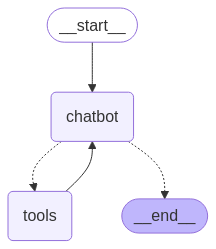

In [45]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [46]:
user_input = "LangGraph에서 '노드'란 무엇인가요?"
state = {"messages": [HumanMessage(content=user_input)]}
response = graph.invoke(state)

print(response["messages"][-1].content)

LangGraph에서 '노드'는 그래프 구조의 기본 단위로, 일반적으로 특정 정보나 데이터를 표현하는 점입니다. 각 노드는 다른 노드와 연결되어 있으며, 이 연결은 데이터 간의 관계를 나타냅니다. LangGraph는 주로 언어 모델이나 데이터 흐름을 구성하는 데 사용되며, 노드는 이 프로세스를 지원하는 요소로 работ합니다.

더 자세한 내용을 알고 싶다면, 아래 링크에서 확인할 수 있습니다:
- [LangGraph 개념과 활용](https://brunch.co.kr/@@hqFh/132)
- [AI Agent 개발](https://blog.kyobodts.co.kr/2025/02/28/ai-agent-%EA%B0%9C%EB%B0%9C%EC%9D%98-%ED%95%B5%EC%8B%AC-rag%EC%99%80-langchain-langgraph-%EB%B9%84%EA%B5%90-%EB%B6%84%EC%84%9D/)
